## `xgboost` weighted multi target

In [1]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [23]:
def make_custom_obj(weight_matrix):
    """
    Custom objective with individual weight for each Y element.
    
    Args:
        weight_matrix: array of shape (n, k) - weight for each Y[i, j]
    """
    # Flatten weight matrix in the same order as XGBoost
    # weights = weight_matrix.ravel()
    
    def objective(y_true, y_pred):
        grad =  weight_matrix*(y_pred - y_true.reshape(y_pred.shape))
        hess =  weight_matrix*np.ones_like(y_pred)
        
        return grad, hess

    return objective

## Example with Barra returns

In [51]:
# Generate sample data
np.random.seed(42)
n, p, k = 1000, 10, 2  # n samples, p features, k targets

# Create feature matrix X (n x p)
X = np.random.randn(n, p)
R = np.ones((p,k))
R[:,1]=-1
e = np.random.randn(n, k)

Y = X @ R + e

W = np.ones_like(Y)
W[int(n/2):,0]=0
W[:int(n/2),1]=0

n_estimators=3

model = XGBRegressor(
    n_estimators=n_estimators,
    max_depth=2,
    learning_rate=0.1,
    tree_method="hist",
    multi_strategy="multi_output_tree",
    random_state=42,
    objective=make_custom_obj(W)
)
model.fit(X, Y)

Y_hat = model.predict(X)

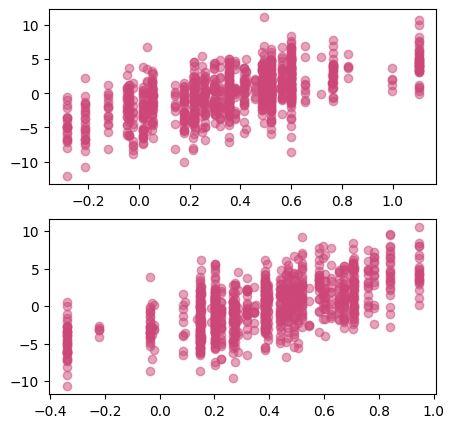

In [52]:
cmap = cm.plasma
fig, ax =plt.subplots(2,1,figsize=(5,5))
for i in range(k):
    ax[i].plot(Y_hat[:,i], Y[:,i], "o", alpha=0.5, color=cmap(0.5))

In [59]:
# Extract split points from JSON
model.save_model('temp_model.json')
with open('temp_model.json', 'r') as f:
    model_data = json.load(f)

trees = model_data['learner']['gradient_booster']['model']['trees']

def extract_splits(tree_node, splits=None, depth=0):
    """Recursively extract split points from a tree."""
    if splits is None:
        splits = []
    
    if 'split_condition' in tree_node:
        splits.append({
            'depth': depth,
            'feature': tree_node['split_index'],
            'threshold': tree_node['split_condition']
        })
        
        # Traverse children
        if 'children' in tree_node:
            for child in tree_node['children']:
                extract_splits(child, splits, depth + 1)
    
    return splits

print("="*70)
print("VERIFYING SHARED SPLIT POINTS IN MULTI_OUTPUT_TREE")
print("="*70)
print(f"\nModel configuration:")
print(f"  - n_estimators: {n_estimators}")
print(f"  - Number of targets (k): {k}")
print(f"  - Total trees: {len(trees)}")
print(f"  - Trees per boosting round: {k}")

# Compare splits across targets for each boosting round
for round_idx in range(n_estimators):
    print(f"\n{'='*70}")
    print(f"BOOSTING ROUND {round_idx}")
    print(f"{'='*70}")
    
    # Get trees for this round (one per target)
    round_trees = trees[round_idx * k : (round_idx + 1) * k]
    
    # Extract splits for each target's tree
    all_splits = []
    for target_idx, tree in enumerate(round_trees):
        splits = extract_splits(tree)
        all_splits.append(splits)
        
        print(f"\nTarget {target_idx} (Tree {round_idx * k + target_idx}):")
        for s in splits:
            print(f"  Depth {s['depth']}: Feature X{s['feature']} < {s['threshold']:.6f}")
    
    # Verify splits are identical across targets
    print(f"\n{'-'*70}")
    print("VERIFICATION: Are split points identical across all targets?")
    print(f"{'-'*70}")
    
    if len(all_splits) > 1:
        reference_splits = all_splits[0]
        all_same = True
        
        for target_idx in range(1, k):
            if len(all_splits[target_idx]) != len(reference_splits):
                print(f"❌ Target {target_idx}: Different number of splits!")
                all_same = False
                continue
            
            for i, (s1, s2) in enumerate(zip(reference_splits, all_splits[target_idx])):
                if (s1['feature'] != s2['feature'] or 
                    abs(s1['threshold'] - s2['threshold']) > 1e-10):
                    print(f"❌ Target {target_idx}, Split {i}: DIFFERENT")
                    print(f"   Target 0: X{s1['feature']} < {s1['threshold']:.6f}")
                    print(f"   Target {target_idx}: X{s2['feature']} < {s2['threshold']:.6f}")
                    all_same = False
        
        if all_same:
            print("✅ ALL SPLIT POINTS ARE IDENTICAL across all targets!")
            print("   This confirms multi_output_tree uses SHARED tree structure.")
    else:
        print("Only one target, no comparison needed.")

print(f"\n{'='*70}")
print("CONCLUSION")
print(f"{'='*70}")
print("In multi_output_tree strategy:")
print("  • Split features are THE SAME for all targets")
print("  • Split thresholds are THE SAME for all targets")
print("  • Only the LEAF VALUES differ per target")
print("  • This makes training k× faster than independent models")

VERIFYING SHARED SPLIT POINTS IN MULTI_OUTPUT_TREE

Model configuration:
  - n_estimators: 3
  - Number of targets (k): 2
  - Total trees: 3
  - Trees per boosting round: 2

BOOSTING ROUND 0

Target 0 (Tree 0):

Target 1 (Tree 1):

----------------------------------------------------------------------
VERIFICATION: Are split points identical across all targets?
----------------------------------------------------------------------
✅ ALL SPLIT POINTS ARE IDENTICAL across all targets!
   This confirms multi_output_tree uses SHARED tree structure.

BOOSTING ROUND 1

Target 0 (Tree 2):

----------------------------------------------------------------------
VERIFICATION: Are split points identical across all targets?
----------------------------------------------------------------------
Only one target, no comparison needed.

BOOSTING ROUND 2

----------------------------------------------------------------------
VERIFICATION: Are split points identical across all targets?
-----------------